<a href="https://colab.research.google.com/github/Sevnhutsjr/ST311_Group11_Project/blob/main/Combination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for Combining Models

## Model 1 - Whisper Model

In [ ]:
import torch
import torchaudio
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# 1. Load Whisper Tiny
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print(f"Running on: {device}")

# 2. Upload wav
from google.colab import files
uploaded = files.upload()

# 3. Select walter wav
audio_path = list(uploaded.keys())[0]

# 4. Load audio and resample if necessary
waveform, sr = torchaudio.load(audio_path)
print(f"Original sample rate: {sr}")

# Resample to 16000 Hz for Whisper
if sr != 16000:
    resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
    waveform = resampler(waveform)

# Convert stereo to mono
waveform = waveform.mean(dim=0).numpy()

# 5. Transcribe with Whisper Tiny
inputs = processor.feature_extractor(
    waveform, sampling_rate=16000, return_tensors="pt"
).input_features.to(device)

predicted_ids = model.generate(inputs)
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

print(f"\nTranscription:\n{transcription}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

Running on: cpu


Saving WalterWhite.wav to WalterWhite.wav
Original sample rate: 48000


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Transcription:
 You clearly don't know who you're talking to. So let me clue you in. I am not in danger, Skyler. I am the danger. A guy opens his door and gets shot and you think of that of me. Now I am the one who knocks.


## Model 2 - Audio Detection

## Model 3 Image Emotion

In [ ]:
#Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


With this import please import CNN model (pt file)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving emotion_cnn_model.pt to emotion_cnn_model.pt


Model Architecture

In [ ]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 7)  # 7 emotion classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EmotionCNN().to(device)
model.load_state_dict(torch.load("emotion_cnn_model.pt", map_location=device))
model.eval()

class_names = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),  # Match training size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [ ]:
def predict_emotion(image_path):
    image = Image.open(image_path).convert("L")  # Grayscale
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(image)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    # Store probabilities in a dictionary
    prob_dict = {class_names[i]: float(probs[i]) for i in range(len(class_names))}

    # Plot
    plt.figure(figsize=(8, 4))
    plt.bar(class_names, probs, color='skyblue')
    plt.title("Emotion Softmax Prediction")
    plt.ylabel("Probability")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

    return prob_dict


Using this next upload file upload image (save image as WW_IATOWK on computer)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving WW_IATOWK.jpg to WW_IATOWK.jpg


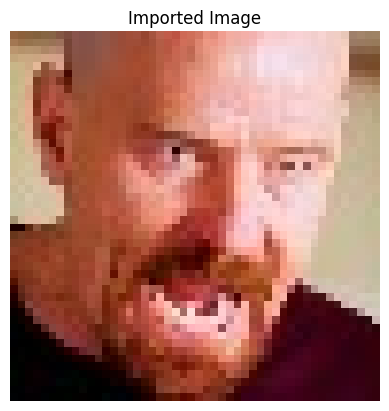

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image_path = "WW_IATOWK.jpg"
img = Image.open(image_path)

# Show the image
plt.imshow(img, cmap="gray")
plt.title("Imported Image")
plt.axis("off")
plt.show()


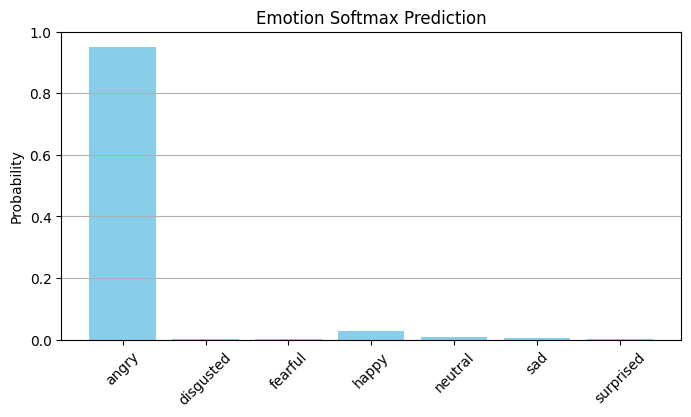

{'angry': 0.9502477049827576, 'disgusted': 0.0034035146236419678, 'fearful': 0.003382481634616852, 'happy': 0.027218841016292572, 'neutral': 0.009947200305759907, 'sad': 0.004052800592035055, 'surprised': 0.0017473987536504865}


In [ ]:
image_path = "WW_IATOWK.jpg"
result = predict_emotion(image_path)
print(result)


## Combination of 3 Models

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model="j-hartmann/emotion-english-roberta-large", top_k=None)
text_sentiment = classifier(transcription)

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
text_sentiment

[[{'label': 'fear', 'score': 0.5588914155960083},
  {'label': 'anger', 'score': 0.2793048918247223},
  {'label': 'neutral', 'score': 0.07717638462781906},
  {'label': 'surprise', 'score': 0.04157564416527748},
  {'label': 'disgust', 'score': 0.020445946604013443},
  {'label': 'sadness', 'score': 0.01873437687754631},
  {'label': 'joy', 'score': 0.0038713645190000534}]]

In [ ]:
import numpy as np

emotions=text_sentiment[0]
desired_order = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

label_score_map = {item['label']: item['score'] for item in emotions}

ordered_scores_text = [label_score_map[label] for label in desired_order]
text_array = np.array(ordered_scores_text)


labels_order = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
image_array = np.array([prob_dict[label] for label in labels_order])

In [ ]:
text_array

array([0.27930489, 0.02044595, 0.55889142, 0.00387136, 0.07717638,
       0.01873438, 0.04157564])

In [ ]:
def count_words(input_string):
    words = input_string.split()
    return len(words)

def sentiment_combiner(transcription, text, image, audio): #Assuming the audio is the best classifier
  sentence_length= count_words(transcription)
  if sentence_length >=100:
    sentiment = (text + 1.75*audio + 0.25*image)/3

  elif sentence_length < 100 and sentence_length>=10:
    weight= 1 + (sentence_length-10)/100
    remaining = (3-weight)/2
    sentiment = (weight*audio + remaining*text + remaining*image)/3

  elif sentence_length <=5 and sentence_length >=1:
    weight = sentence_length/5
    remaining=(3-weight)/2
    sentiment =(weight*text + remaining*audio + remaining*image)/3
  else:
    sentiment = (text+image+audio)/3

  return sentiment

In [ ]:
sentiment_array = sentiment_combiner(transcription, text_array, image_array, audio_array)
sentiment = {desired_order[i]: sentiment_array[i] for i in range(len(desired_order))}
print(sentiment)
#End of coding!